In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## 1 获取和读取数据集

In [2]:
train_data = pd.read_csv('../data/kaggle_house/train.csv')
test_data = pd.read_csv('../data/kaggle_house/test.csv')
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


## 2 预处理数据

In [3]:
# 把第一个特征id删掉
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:-1]))
# 缺失值替换相应特征平均值，特征缩放到零均值和单位方差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())) # 对数值特征标准化
all_features[numeric_features] = all_features[numeric_features].fillna(0) # 缺失值填充
# na处理
all_features = pd.get_dummies(all_features, dummy_na=True)

In [4]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, 
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, 
                              dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1),
                           dtype=torch.float32)

## 3 训练模型

In [5]:
loss = nn.MSELoss()
num_inputs = train_features.shape[1]

net = nn.Sequential(nn.Linear(num_inputs, 1))

# 更新相对误差衡量价格差
def log_rmse(net, features, labels):
    clipped_pred = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_pred), torch.log(labels)))
    return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## 4 K折交叉验证

In [6]:
def get_k_fold_data(k, i, X, y):
    assert k > 1 
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [7]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        # net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## 5 模型选择

2
fold 1, train log rmse 0.170467, valid log rmse 0.156868
fold 2, train log rmse 0.132652, valid log rmse 0.146536
fold 3, train log rmse 0.124463, valid log rmse 0.139609
fold 4, train log rmse 0.128112, valid log rmse 0.123733
fold 5, train log rmse 0.119334, valid log rmse 0.145182
5-折验证: 平均训练log rmse: 0.135005, 平均验证log rmse: 0.142386


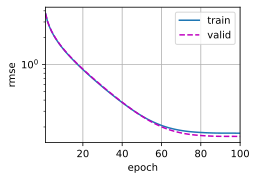

In [8]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

## 6 预测

In [9]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    # net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    # 下面[0]指从二维矩阵中提取一维数组作为输入
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0]) 
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 0.122827


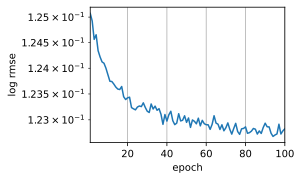

In [10]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

In [11]:
preds = net(test_features).detach().numpy()
pd.Series(preds.reshape(1, -1)[0])

0       110002.492188
1       145960.234375
2       174035.515625
3       186378.828125
4       198169.812500
            ...      
1454     72645.046875
1455     77298.031250
1456    173127.953125
1457    106361.203125
1458    225836.218750
Length: 1459, dtype: float32